In [43]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report,roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [8]:
df = pd.read_csv('data/ratings.dat', header=None, sep = '::', engine = 'python')
df.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [9]:
# check unique values
n_users = df['user_id'].nunique()
n_movies = df['movie_id'].nunique()

print(f"Number of users: {n_users}")
print(f"Number of movies: {n_movies}")

Number of users: 6040
Number of movies: 3706


In [12]:
# construct a 6040 by 3706 matrix with each row contains movie ratings from a user, and each column represents a movie
def load_user_rating_data(df, n_users, n_movies):
    data = np.zeros([n_users, n_movies], dtype = np.intc)
    movie_id_mapping = {}
    for user_id, movie_id, rating in zip(df['user_id'], df['movie_id'], df['rating']):
        user_id = int(user_id) - 1
        if movie_id not in movie_id_mapping:
            movie_id_mapping[movie_id] = len(movie_id_mapping)
        data[user_id, movie_id_mapping[movie_id]] = rating
    return data, movie_id_mapping

In [13]:
data, movie_id_mapping = load_user_rating_data(df, n_users, n_movies)

In [14]:
# analyzing the data distribution for the identify the class imbalance
values, counts = np.unique(data, return_counts=True)
for value, count in zip(values, counts):
    print(f'Number of rating {value}: {count}')

Number of rating 0: 21384031
Number of rating 1: 56174
Number of rating 2: 107557
Number of rating 3: 261197
Number of rating 4: 348971
Number of rating 5: 226310


In [15]:
print(df['movie_id'].value_counts())

movie_id
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
872        1
2703       1
2845       1
3607       1
2909       1
Name: count, Length: 3706, dtype: int64


In [17]:
target_movie_id = 2858
X_raw = np.delete(data, movie_id_mapping[target_movie_id], axis=1)
Y_raw = data[:, movie_id_mapping[target_movie_id]]
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

Shape of X: (3428, 3705)
Shape of Y: (3428,)


In [18]:
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1
n_pos = (Y == 1).sum()
n_neg = (Y == 0).sum()
print(f'{n_pos} positive samples and {n_neg} negative samples.')

2853 positive samples and 575 negative samples.


In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2, random_state=42)
print(len(Y_train), len(Y_test))

2742 686


In [23]:
clf = MultinomialNB(alpha=1.0, fit_prior=True)

In [24]:
clf.fit(X_train, Y_train)

MultinomialNB()

In [25]:
prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[0:10])

[[7.50487439e-23 1.00000000e+00]
 [1.01806208e-01 8.98193792e-01]
 [3.57740570e-10 1.00000000e+00]
 [1.00000000e+00 2.94095407e-16]
 [1.00000000e+00 2.49760836e-25]
 [7.62630220e-01 2.37369780e-01]
 [3.47479627e-05 9.99965252e-01]
 [2.66075292e-11 1.00000000e+00]
 [5.88493563e-10 9.99999999e-01]
 [9.71326867e-09 9.99999990e-01]]


In [ ]:
prediction = clf.predict(X_test)
print(prediction[:10])

[1 1 1 0 0 0 1 1 1 1]


In [27]:
accuracy = clf.score(X_test, Y_test)
print(f'The accuracy is: {accuracy*100:.1f}%')

The accuracy is: 71.6%


In [29]:
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

[[ 60  47]
 [148 431]]


In [31]:
precision_score(Y_test, prediction, pos_label=1)

0.9016736401673641

In [32]:
recall_score(Y_test, prediction, pos_label=1)

0.7443868739205527

In [33]:
f1_score(Y_test, prediction, pos_label=1)

0.815515610217597

In [36]:
report = classification_report(Y_test, prediction)
print(report)

              precision    recall  f1-score   support

           0       0.29      0.56      0.38       107
           1       0.90      0.74      0.82       579

    accuracy                           0.72       686
   macro avg       0.60      0.65      0.60       686
weighted avg       0.81      0.72      0.75       686



In [37]:
pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.1, 0.05)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            # if truth and prediction are both 1
            if y == 1:
                true_pos[i] += 1
# if truth is 0 while prediction is 1
            else:
                false_pos[i] += 1
        else:
            break

In [38]:
n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()
true_pos_rate = [tp / n_pos_test for tp in true_pos]
false_pos_rate = [fp / n_neg_test for fp in false_pos]

In [ ]:
# analyzing the data distribution for the identify the class imbalance
values, counts = np.unique(data, return_counts=True)
for value, count in zip(values, counts):
    print(f'Number of rating {value}: {count}')

Number of rating 0: 21384031
Number of rating 1: 56174
Number of rating 2: 107557
Number of rating 3: 261197
Number of rating 4: 348971
Number of rating 5: 226310


C:\Users\erand\AppData\Local\Temp\ipykernel_6136\3369746105.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc = "lower right")


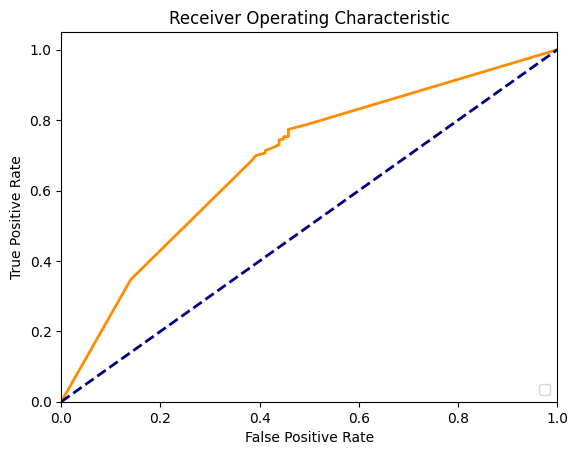

In [40]:
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate,color='darkorange', lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()

In [42]:
roc_auc_score(Y_test, pos_prob)

np.float64(0.6857375752586637)

In [45]:
k = 5
k_fold = StratifiedKFold(n_splits=k, random_state=42,shuffle=True)

In [46]:
smoothing_factor_option = [1, 2, 3, 4, 5, 6]
fit_prior_option = [True, False]
auc_record = {}

In [48]:
for train_indices, test_indices in k_fold.split(X, Y):
    X_train_k, X_test_k= X[train_indices], X[test_indices]
    Y_train_k, Y_test_k = Y[train_indices], Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha,fit_prior=fit_prior)
            clf.fit(X_train_k, Y_train_k)
            prediction_prob = clf.predict_proba(X_test_k)
        pos_prob = prediction_prob[:, 1]
        auc = roc_auc_score(Y_test_k, pos_prob)
        auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior, 0.0)


In [49]:
for smoothing, smoothing_record in auc_record.items():
    for fit_prior, auc in smoothing_record.items():
        print(f' {smoothing} {fit_prior} {auc/k:.5f}')

 1 False 0.65274
 2 False 0.65274
 3 False 0.65322
 4 False 0.65430
 5 False 0.65448
 6 False 0.65404


In [50]:
clf = MultinomialNB(alpha=2.0, fit_prior=False)
clf.fit(X_train, Y_train)
pos_prob = clf.predict_proba(X_test)[:, 1]
print('AUC with the best model:', roc_auc_score(Y_test,pos_prob))

AUC with the best model: 0.6862056720417091
